# CSV --> Graph Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file. 

In [1]:
import os

import pandas as pd
from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, IngestionGenerator, LLM, PyIngest
from neo4j_runway.utils import test_database_connection

load_dotenv()

True

## Initialize Test Data

The USER_GENERATED_INPUT variable contains a General Discription and feature descriptions for each feature we'd like to use in our graph.

In [2]:
USER_GENERATED_INPUT = {
    'General Description': 'This is data on different countries.',
    'id': 'unique id for a country.',
    'name': 'the country name.',
    'phone_code': 'country area code.',
    'capital': 'the capital of the country.',
    'currency_name': "name of the country's currency.",
    'region': 'primary region of the country.',
    'subregion': 'subregion location of the country.',
    'timezones': 'timezones contained within the country borders.',
    'latitude': 'the latitude coordinate of the country center.',
    'longitude': 'the longitude coordinate of the country center.'
}

In [3]:
data = pd.read_csv("data/csv/countries.csv")

## Initialize LLM

We now initialize the LLM to use in data discovery and data model creation.

In [4]:
llm = LLM()

## Discovery

We now load the above data into a Discovery object.

In [5]:
disc = Discovery(llm=llm, user_input=USER_GENERATED_INPUT, data=data)

In [6]:
discovery = disc.run()
print(discovery)

Your dataset provides a comprehensive overview of various attributes related to countries around the world. Here's a preliminary analysis based on the summary you've provided:

### General Characteristics:
- **Entries and Completeness**: The dataset consists of 250 entries, each representing a country. Most columns are fully populated, but there are a few missing values in `capital`, `region`, and `subregion`. Specifically, `capital` is missing in 5 entries, `region` in 2, and `subregion` in 3. These missing values could be due to various reasons, such as territories without a designated capital or regions that are difficult to classify.
- **Data Types**: The dataset features a mix of numerical (`int64` and `float64`) and categorical (`object`) data types. This variety suggests that the dataset captures both quantitative measures (like `latitude` and `longitude`) and qualitative attributes (like `name`, `capital`, and `currency_name`).

### Key Features:
1. **Unique Identifiers and Nam

## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. We don't *need* the discovery information for this step to work, but it provides much better models.

In [7]:
gdm = GraphDataModeler(
    llm=llm,
    user_input=USER_GENERATED_INPUT,
    discovery=disc.discovery,
    general_data_description=disc.general_description,
    categorical_data_description=disc.categorical_data_description,
    numeric_data_description=disc.numeric_data_description,
    feature_descriptions=disc.feature_descriptions
)

We now generate our first pass data model.

In [8]:
initial_model = gdm.create_initial_model()

recieved a valid response


In [9]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True), Property(name='name', type='str', csv_mapping='name', is_unique=False)]), Node(label='Capital', properties=[Property(name='capital', type='str', csv_mapping='capital', is_unique=True)]), Node(label='Region', properties=[Property(name='region', type='str', csv_mapping='region', is_unique=True)]), Node(label='Subregion', properties=[Property(name='subregion', type='str', csv_mapping='subregion', is_unique=True)]), Node(label='Currency', properties=[Property(name='currencyName', type='str', csv_mapping='currency_name', is_unique=True)])], relationships=[Relationship(type='HAS_CAPITAL', properties=[], source='Country', target='Capital'), Relationship(type='LOCATED_IN_REGION', properties=[], source='Country', target='Region'), Relationship(type='PART_OF_SUBREGION', properties=[], source='Country', target='Subregion'), Relationship(type='USES_CURRENCY', properties=[], source=

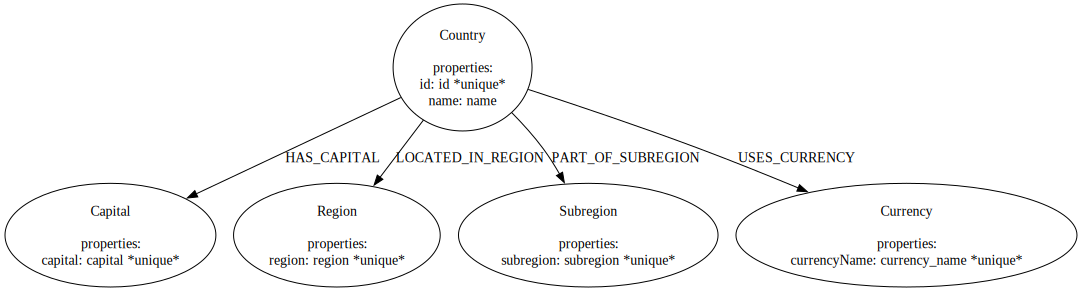

In [10]:
gdm.current_model.visualize()

This doesn't look quite right, so let's prompt the LLM to make some corrections.

In [11]:
gdm.iterate_model(iterations=1, user_corrections="Make Region node have a HAS_SUBREGION relationship with Subregion node. Remove The relationship between Country and Region.")

recieved a valid response


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True), Property(name='name', type='str', csv_mapping='name', is_unique=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', is_unique=False), Property(name='latitude', type='float', csv_mapping='latitude', is_unique=False), Property(name='longitude', type='float', csv_mapping='longitude', is_unique=False)]), Node(label='Capital', properties=[Property(name='capital', type='str', csv_mapping='capital', is_unique=True)]), Node(label='Region', properties=[Property(name='region', type='str', csv_mapping='region', is_unique=True)]), Node(label='Subregion', properties=[Property(name='subregion', type='str', csv_mapping='subregion', is_unique=True)]), Node(label='Currency', properties=[Property(name='currencyName', type='str', csv_mapping='currency_name', is_unique=True)]), Node(label='Timezone', properties=[Property(name='timezones', type='str', csv_mapping='timez

In [12]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True), Property(name='name', type='str', csv_mapping='name', is_unique=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', is_unique=False), Property(name='latitude', type='float', csv_mapping='latitude', is_unique=False), Property(name='longitude', type='float', csv_mapping='longitude', is_unique=False)]), Node(label='Capital', properties=[Property(name='capital', type='str', csv_mapping='capital', is_unique=True)]), Node(label='Region', properties=[Property(name='region', type='str', csv_mapping='region', is_unique=True)]), Node(label='Subregion', properties=[Property(name='subregion', type='str', csv_mapping='subregion', is_unique=True)]), Node(label='Currency', properties=[Property(name='currencyName', type='str', csv_mapping='currency_name', is_unique=True)]), Node(label='Timezone', properties=[Property(name='timezones', type='str', csv_mapping='timez

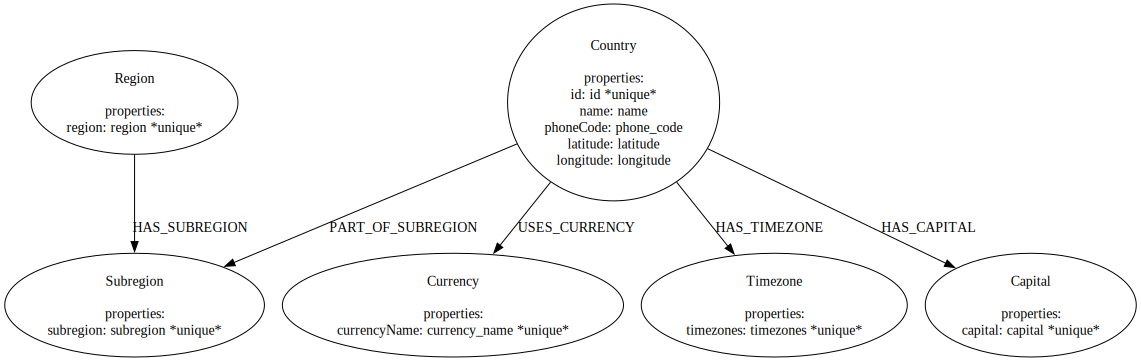

In [13]:
gdm.current_model.visualize()

This is good enough for our demo. We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We should provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [14]:

gen = IngestionGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         csv_dir="data/csv/", csv_name="countries.csv")

In [15]:
pyingest_yaml = gen.generate_pyingest_yaml_string()
# gen.generate_pyingest_yaml_file(file_name="countries")
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: file:./

pre_ingest:
  - CREATE CONSTRAINT country_id IF NOT EXISTS FOR (n:Country) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT capital_capital IF NOT EXISTS FOR (n:Capital) REQUIRE n.capital IS UNIQUE;
  - CREATE CONSTRAINT region_region IF NOT EXISTS FOR (n:Region) REQUIRE n.region IS UNIQUE;
  - CREATE CONSTRAINT subregion_subregion IF NOT EXISTS FOR (n:Subregion) REQUIRE n.subregion IS UNIQUE;
  - CREATE CONSTRAINT currency_currencyname IF NOT EXISTS FOR (n:Currency) REQUIRE n.currencyName IS UNIQUE;
  - CREATE CONSTRAINT timezone_timezones IF NOT EXISTS FOR (n:Timezone) REQUIRE n.timezones IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Country {id: row.id})
    SET n.name = row.name, n.phoneCode = row.phone_code, n.latitude = row.latitude, n.longitude = row.longitude
  url: $BASE/data/csv/countries.csv
- chunk_size: 100

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a modified PyIngest function. This version of PyIngest works only with pre-loaded Pandas DataFrames. First let's confirm our connection though.

In [16]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), "password": os.environ.get("NEO4J_PASSWORD"), "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [17]:
PyIngest(yaml_string=pyingest_yaml, dataframe=data)

File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:39.827408


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-05-01 08:22:40.125561
{} : Completed file 2024-05-01 08:22:40.167858
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.168291
loading... 1 2024-05-01 08:22:40.221640
{} : Completed file 2024-05-01 08:22:40.254571
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.255168
loading... 1 2024-05-01 08:22:40.292997
{} : Completed file 2024-05-01 08:22:40.305638
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.306033
loading... 1 2024-05-01 08:22:40.343980
{} : Completed file 2024-05-01 08:22:40.363183
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.363928


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py

loading... 1 2024-05-01 08:22:40.408383
{} : Completed file 2024-05-01 08:22:40.432961
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.433556
loading... 1 2024-05-01 08:22:40.486280
{} : Completed file 2024-05-01 08:22:40.514072
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.514731


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-05-01 08:22:40.643983
{} : Completed file 2024-05-01 08:22:40.672019
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.672436
loading... 1 2024-05-01 08:22:40.757121
{} : Completed file 2024-05-01 08:22:40.790761
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.791222
loading... 1 2024-05-01 08:22:40.851345


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


{} : Completed file 2024-05-01 08:22:40.874286
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.874825
loading... 1 2024-05-01 08:22:40.958156
{} : Completed file 2024-05-01 08:22:40.981538
File {} file:.//data/csv/countries.csv
loading... 0 2024-05-01 08:22:40.982212
loading... 1 2024-05-01 08:22:41.041406
{} : Completed file 2024-05-01 08:22:41.055082


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


If we check our database we can see that we've ingested our CSV according to the data model we've created!

![countries-graph.png](./images/countries-graph-white-background.png)